In [19]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import random
import os
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor

%matplotlib inline

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(42) # Seed 고정

In [110]:
from sklearn import metrics 
def lg_nrmse(gt, preds):
    # 각 Y Feature별 NRMSE 총합
    # Y_01 ~ Y_08 까지 20% 가중치 부여
    all_nrmse = []
    for idx in range(0,14): # ignore 'ID'
        rmse = metrics.mean_squared_error(gt[:,idx], preds[:,idx], squared=False)
        nrmse = rmse/np.mean(np.abs(gt[:,idx]))
        all_nrmse.append(nrmse)
    print(all_nrmse[:8])
    score = 1.2 * np.sum(all_nrmse[:8]) + 1.0 * np.sum(all_nrmse[8:14])
    return score

# 클리핑 기법

In [22]:
num_cols = ["X_01","X_02","X_03","X_05","X_06","X_07","X_08","X_09","X_12","X_13","X_14","X_15","X_16","X_17","X_18","X_19","X_20","X_21","X_22","X_24","X_25","X_26","X_27","X_28","X_29","X_30","X_31","X_32","X_33","X_34","X_35","X_36","X_37","X_38","X_39","X_40","X_41","X_42","X_43","X_44","X_45","X_49","X_50","X_51","X_52","X_53","X_54","X_55","X_56"]
# -----------------------------------
# clipping
# -----------------------------------
# 데이터 읽어오기
from sklearn.model_selection import train_test_split

train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv("./test.csv")

train_df, valid_df = train_test_split(train_df, train_size=0.8,random_state=42)

train_x = train_df.filter(regex='X')
train_y = train_df.filter(regex='Y')
test_x = test_df.filter(regex="X")

valid_x = valid_df.filter(regex='X') # Input : X Featrue
valid_y = valid_df.filter(regex='Y') # Output : Y Feature
# -----------------------------------
# 열마다 학습 데이터의 1%, 99% 지점을 확인
p01 = train_x[num_cols].quantile(0.03)
p99 = train_x[num_cols].quantile(0.97)

p01_valid = valid_x[num_cols].quantile(0.03)
p99_vaild = valid_x[num_cols].quantile(0.97)

# 1％점 이하의 값은 1%점으로, 99%점 이상의 값은 99%점으로 클리핑
train_x = train_x[num_cols].clip(p01, p99, axis=1)
test_x = test_x[num_cols].clip(p01, p99, axis=1)
valid_x = valid_x[num_cols].clip(p01_valid, p99_vaild, axis=1)
# -----------------------------------


# 기본 xgb.XGBRegressor의 성능을 측정해 보자

In [23]:
# 학습후 리더보드 확인

import xgboost as xgb
XGB = MultiOutputRegressor(xgb.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma = 0, subsample=0.75, colsample_bytree = 1, max_depth=7)).fit(train_x, train_y)
valid_preds = XGB.predict(valid_x)
score = lg_nrmse(valid_y.values,valid_preds)
print(score)
from xgboost import plot_importance
plot_importance(XGB.get_booster().get_fscore())

[0.2569175335113314, 0.3558376311821327, 0.34906821002606536, 0.18855326939006656, 0.07919843358631094, 0.09861696124229752, 0.12852124155333047, 0.024144212703855437]
1.9444058380148388


AttributeError: 'MultiOutputRegressor' object has no attribute 'get_booster'

## 현재 Y_01
- 0.2569175335113314
- 이것의 성능을 향상시켜 보자

[0.2573595413863821, 0.35604713899391244, 0.34906786211855056, 0.18933551446304756, 0.0790237661692036, 0.09548581611302315, 0.12866462354563665, 0.02415634757454449]
1.942351038022796


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

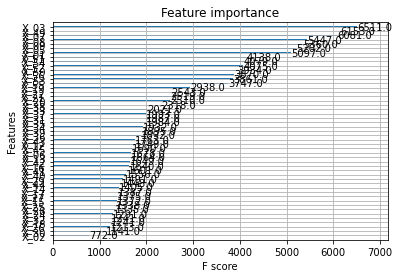

In [24]:
XGB = xgb.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma = 0, subsample=0.75, colsample_bytree = 1, max_depth=7).fit(train_x, train_y)
valid_preds = XGB.predict(valid_x)
score = lg_nrmse(valid_y.values,valid_preds)
print(score)
from xgboost import plot_importance
plot_importance(XGB.get_booster().get_fscore())

# X 변수 추가

In [91]:
num_col = ["X_01","X_02","X_03","X_05","X_06","X_07","X_08","X_09","X_12","X_13","X_14","X_15","X_16","X_17","X_18","X_19","X_20","X_21","X_22","X_24","X_25","X_26","X_27","X_28","X_29","X_30","X_31","X_32","X_33","X_34","X_35","X_36","X_37","X_38","X_39","X_40","X_41","X_42","X_43","X_44","X_45","X_49","X_50","X_51","X_52","X_53","X_54","X_55","X_56"]
select_cols = []
import random
for i in range(57,1000):
    first = random.choice(num_col)
    second = random.choice(num_col)
    train_x["X_%02d"%i] = train_x[first] * train_x[second]
    valid_x["X_%02d"%i] = valid_x[first] * valid_x[second]
    select_cols.append((i,first,second))

## fscore로 가르기

[0.25524942975642007, 0.353775273528689, 0.3472977581891331, 0.18853374263704623, 0.07931192437003588, 0.10118799544815536, 0.1286838160736608, 0.025134831532234152]
파생변수 기본 스코어 1.947455436974435


C:\Users\Public\Documents\ESTsoft\CreatorTemp/ipykernel_25152/3384065667.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  new_data[i] = train_x[i]
C:\Users\Public\Documents\ESTsoft\CreatorTemp/ipykernel_25152/3384065667.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  new_data_vaild[i] = valid_x[i]


f_score_standard가 1000 일때의 그래프
[0.25539365217573917, 0.3539828397782697, 0.34739740831637067, 0.18839807382041293, 0.07926170975936779, 0.09732624165581513, 0.1287443294772955, 0.0251507567188994]
f_score_standard로 파생변수 잘랐을때의 점수 1.9433257087486697
그때의 그래프


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

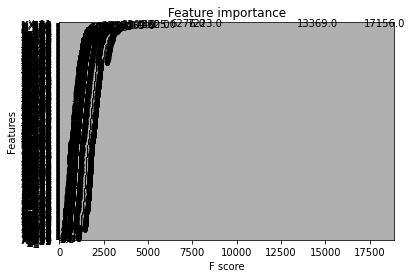

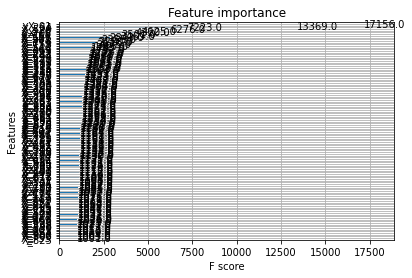

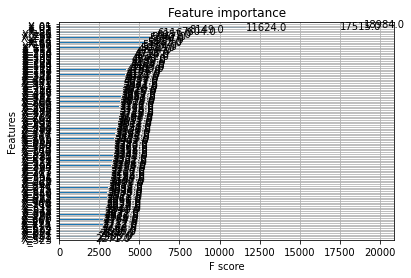

In [93]:
f_score_standard = 1000

import xgboost as xgb
XGB = xgb.XGBRegressor(n_estimators=500, learning_rate=0.01, gamma = 0, subsample=0.75,
 colsample_bytree = 1, max_depth=7,tree_method='gpu_hist', gpu_id=0).fit(train_x, train_y)
valid_preds = XGB.predict(valid_x)
score = lg_nrmse(valid_y.values,valid_preds)
print("파생변수 기본 스코어",score)
from xgboost import plot_importance
plot_importance(XGB.get_booster().get_fscore())


##  기준으로 자르기
a =  XGB.get_booster().get_fscore()
c = {}
new_data = pd.DataFrame()
new_data_vaild = pd.DataFrame()
for i in a:
    if a[i]>f_score_standard:
        new_data[i] = train_x[i]
        new_data_vaild[i] = valid_x[i]
        c[i] = a[i]
print("f_score_standard가",f_score_standard,"일때의 그래프")
from xgboost import plot_importance
plot_importance(c)

import xgboost as xgb
XGB = xgb.XGBRegressor(n_estimators=500, learning_rate=0.01, gamma = 0, subsample=0.75,
 colsample_bytree = 1, max_depth=7,tree_method='gpu_hist', gpu_id=0).fit(new_data, train_y)
valid_preds = XGB.predict(new_data_vaild)
score = lg_nrmse(valid_y.values,valid_preds)
print("f_score_standard로 파생변수 잘랐을때의 점수",score)
print("그때의 그래프")
from xgboost import plot_importance
plot_importance(XGB.get_booster().get_fscore())

[0.25524942975642007, 0.353775273528689, 0.3472977581891331, 0.18853374263704623, 0.07931192437003588, 0.10118799544815536, 0.1286838160736608, 0.025134831532234152]
파생변수 기본 스코어 1.947455436974435
f_score_standard가 1500 일때의 그래프
[0.2560213254661145, 0.354716436639721, 0.34773466580765855, 0.18918674172312272, 0.07949999221192504, 0.1013723842059634, 0.12895721954475456, 0.025223159447859276]
f_score_standard로 파생변수 잘랐을때의 점수 1.9525230491132735
그때의 그래프


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

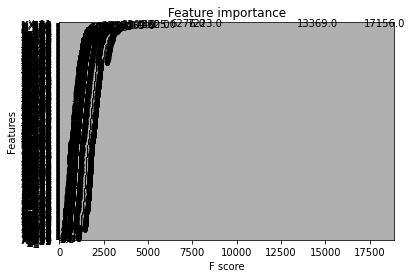

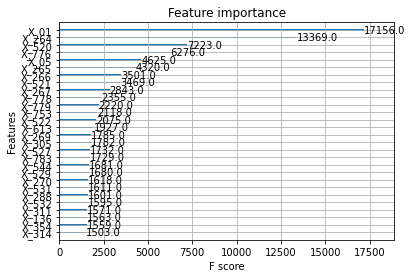

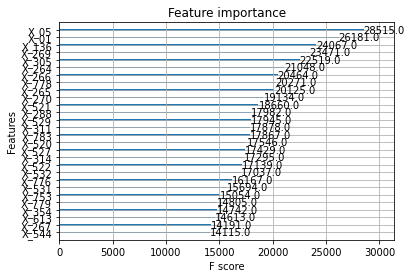

In [94]:
f_score_standard = 1500

import xgboost as xgb
XGB = xgb.XGBRegressor(n_estimators=500, learning_rate=0.01, gamma = 0, subsample=0.75,
 colsample_bytree = 1, max_depth=7,tree_method='gpu_hist', gpu_id=0).fit(train_x, train_y)
valid_preds = XGB.predict(valid_x)
score = lg_nrmse(valid_y.values,valid_preds)
print("파생변수 기본 스코어",score)
from xgboost import plot_importance
plot_importance(XGB.get_booster().get_fscore())


##  기준으로 자르기
a =  XGB.get_booster().get_fscore()
c = {}
new_data = pd.DataFrame()
new_data_vaild = pd.DataFrame()
for i in a:
    if a[i]>f_score_standard:
        new_data[i] = train_x[i]
        new_data_vaild[i] = valid_x[i]
        c[i] = a[i]
print("f_score_standard가",f_score_standard,"일때의 그래프")
from xgboost import plot_importance
plot_importance(c)

import xgboost as xgb
XGB = xgb.XGBRegressor(n_estimators=500, learning_rate=0.01, gamma = 0, subsample=0.75,
 colsample_bytree = 1, max_depth=7,tree_method='gpu_hist', gpu_id=0).fit(new_data, train_y)
valid_preds = XGB.predict(new_data_vaild)
score = lg_nrmse(valid_y.values,valid_preds)
print("f_score_standard로 파생변수 잘랐을때의 점수",score)
print("그때의 그래프")
from xgboost import plot_importance
plot_importance(XGB.get_booster().get_fscore())

[0.25524942975642007, 0.353775273528689, 0.3472977581891331, 0.18853374263704623, 0.07931192437003588, 0.10118799544815536, 0.1286838160736608, 0.025134831532234152]
파생변수 기본 스코어 1.947455436974435


C:\Users\Public\Documents\ESTsoft\CreatorTemp/ipykernel_25152/922103909.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  new_data[i] = train_x[i]
C:\Users\Public\Documents\ESTsoft\CreatorTemp/ipykernel_25152/922103909.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  new_data_vaild[i] = valid_x[i]


f_score_standard가 500 일때의 그래프
[0.2554272644164117, 0.35385760600424276, 0.34706201155958843, 0.18874187002992338, 0.07924389636118087, 0.10115033489933323, 0.12868452616364973, 0.025113591323422935]
f_score_standard로 파생변수 잘랐을때의 점수 1.9475972421752117
그때의 그래프


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

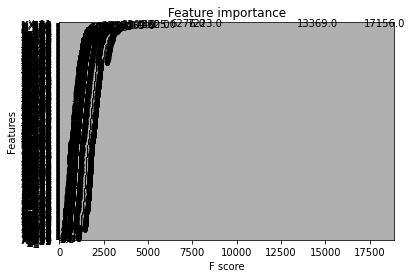

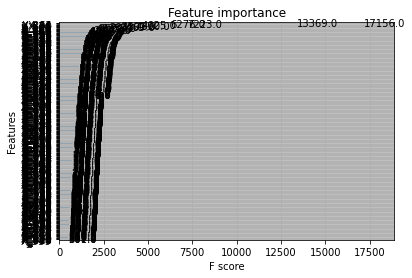

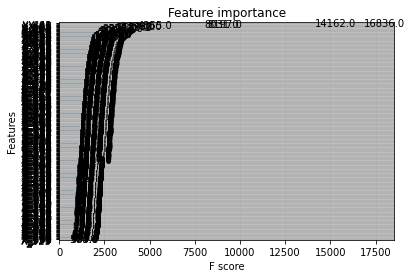

In [99]:
f_score_standard = 500

import xgboost as xgb
XGB = xgb.XGBRegressor(n_estimators=500, learning_rate=0.01, gamma = 0, subsample=0.75,
 colsample_bytree = 1, max_depth=7,tree_method='gpu_hist', gpu_id=0).fit(train_x, train_y)
valid_preds = XGB.predict(valid_x)
score = lg_nrmse(valid_y.values,valid_preds)
print("파생변수 기본 스코어",score)
from xgboost import plot_importance
plot_importance(XGB.get_booster().get_fscore())


##  기준으로 자르기
a =  XGB.get_booster().get_fscore()
c = {}
new_data = pd.DataFrame()
new_data_vaild = pd.DataFrame()
for i in a:
    if a[i]>f_score_standard:
        new_data[i] = train_x[i]
        new_data_vaild[i] = valid_x[i]
        c[i] = a[i]
print("f_score_standard가",f_score_standard,"일때의 그래프")
from xgboost import plot_importance
plot_importance(c)

import xgboost as xgb
XGB = xgb.XGBRegressor(n_estimators=500, learning_rate=0.01, gamma = 0, subsample=0.75,
 colsample_bytree = 1, max_depth=7,tree_method='gpu_hist', gpu_id=0).fit(new_data, train_y)
valid_preds = XGB.predict(new_data_vaild)
score = lg_nrmse(valid_y.values,valid_preds)
print("f_score_standard로 파생변수 잘랐을때의 점수",score)
print("그때의 그래프")
from xgboost import plot_importance
plot_importance(XGB.get_booster().get_fscore())

# clip 없이 진행

In [100]:
from sklearn.model_selection import train_test_split

train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv("./test.csv")

train_df, valid_df = train_test_split(train_df, train_size=0.8,random_state=42)

train_x = train_df.filter(regex='X')
train_y = train_df.filter(regex='Y')
test_x = test_df.filter(regex="X")

valid_x = valid_df.filter(regex='X') # Input : X Featrue
valid_y = valid_df.filter(regex='Y') # Output : Y Feature

In [101]:
num_col = ["X_01","X_02","X_03","X_05","X_06","X_07","X_08","X_09","X_12","X_13","X_14","X_15","X_16","X_17","X_18","X_19","X_20","X_21","X_22","X_24","X_25","X_26","X_27","X_28","X_29","X_30","X_31","X_32","X_33","X_34","X_35","X_36","X_37","X_38","X_39","X_40","X_41","X_42","X_43","X_44","X_45","X_49","X_50","X_51","X_52","X_53","X_54","X_55","X_56"]
select_cols = []
import random
for i in range(57,1000):
    first = random.choice(num_col)
    second = random.choice(num_col)
    train_x["X_%02d"%i] = train_x[first] * train_x[second]
    valid_x["X_%02d"%i] = valid_x[first] * valid_x[second]
    select_cols.append((i,first,second))

C:\Users\Public\Documents\ESTsoft\CreatorTemp/ipykernel_25152/3218919256.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_x["X_%02d"%i] = train_x[first] * train_x[second]
C:\Users\Public\Documents\ESTsoft\CreatorTemp/ipykernel_25152/3218919256.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_x["X_%02d"%i] = valid_x[first] * valid_x[second]
C:\Users\Public\Documents\ESTsoft\CreatorTemp/ipykernel_25152/3218919256.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the 

[0.2556213912923826, 0.35415162558027197, 0.347083366860999, 0.1882953400649282, 0.07928248555834581, 0.09795879394919009, 0.12866304617167076, 0.025111603847307033]
파생변수 기본 스코어 1.9438402059008113


C:\Users\Public\Documents\ESTsoft\CreatorTemp/ipykernel_25152/3384065667.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  new_data[i] = train_x[i]
C:\Users\Public\Documents\ESTsoft\CreatorTemp/ipykernel_25152/3384065667.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  new_data_vaild[i] = valid_x[i]


f_score_standard가 1000 일때의 그래프
[0.25557732669849914, 0.35392837847838166, 0.3472317538762987, 0.18824146795230007, 0.0792207781103783, 0.0987473934888259, 0.12880395465744043, 0.025115916793496163]
f_score_standard로 파생변수 잘랐을때의 점수 1.9447036215848552
그때의 그래프


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

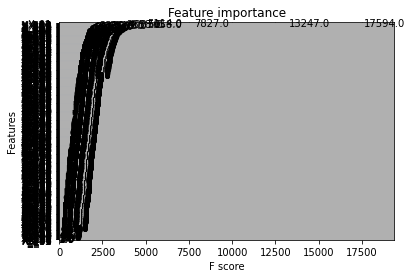

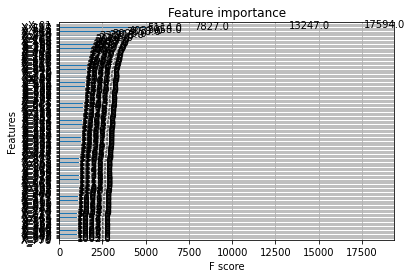

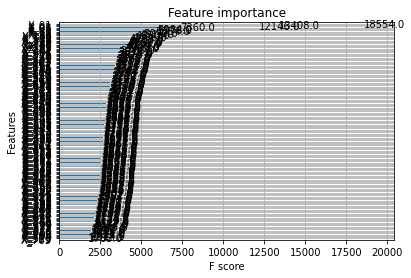

In [102]:
f_score_standard = 1000

import xgboost as xgb
XGB = xgb.XGBRegressor(n_estimators=500, learning_rate=0.01, gamma = 0, subsample=0.75,
 colsample_bytree = 1, max_depth=7,tree_method='gpu_hist', gpu_id=0).fit(train_x, train_y)
valid_preds = XGB.predict(valid_x)
score = lg_nrmse(valid_y.values,valid_preds)
print("파생변수 기본 스코어",score)
from xgboost import plot_importance
plot_importance(XGB.get_booster().get_fscore())


##  기준으로 자르기
a =  XGB.get_booster().get_fscore()
c = {}
new_data = pd.DataFrame()
new_data_vaild = pd.DataFrame()
for i in a:
    if a[i]>f_score_standard:
        new_data[i] = train_x[i]
        new_data_vaild[i] = valid_x[i]
        c[i] = a[i]
print("f_score_standard가",f_score_standard,"일때의 그래프")
from xgboost import plot_importance
plot_importance(c)

import xgboost as xgb
XGB = xgb.XGBRegressor(n_estimators=500, learning_rate=0.01, gamma = 0, subsample=0.75,
 colsample_bytree = 1, max_depth=7,tree_method='gpu_hist', gpu_id=0).fit(new_data, train_y)
valid_preds = XGB.predict(new_data_vaild)
score = lg_nrmse(valid_y.values,valid_preds)
print("f_score_standard로 파생변수 잘랐을때의 점수",score)
print("그때의 그래프")
from xgboost import plot_importance
plot_importance(XGB.get_booster().get_fscore())

In [109]:
valid_preds = XGB.predict(new_data_vaild)
score = lg_nrmse(valid_y.values,valid_preds)
print("f_score_standard로 파생변수 잘랐을때의 점수",score)

[0.25528678124060855, 0.3540090648411242, 0.3465187536275724, 0.1883021226052745, 0.07929734705246029, 0.09824090774706928, 0.128637119455816, 0.02512549362358537]
f_score_standard로 파생변수 잘랐을때의 점수 1.6479046681767868


[0.2556213912923826, 0.35415162558027197, 0.347083366860999, 0.1882953400649282, 0.07928248555834581, 0.09795879394919009, 0.12866304617167076, 0.025111603847307033]
파생변수 기본 스코어 1.9438402059008113
f_score_standard가 1500 일때의 그래프
[0.25625753805035484, 0.3547372442589471, 0.34796605441453915, 0.18880317240678812, 0.07943359083330208, 0.09657008926706669, 0.12900781955742685, 0.025149600374384375]
f_score_standard로 파생변수 잘랐을때의 점수 1.9461860964855877
그때의 그래프


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

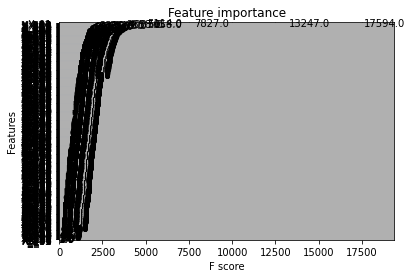

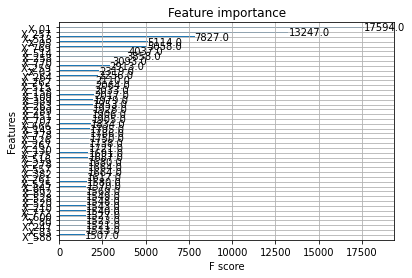

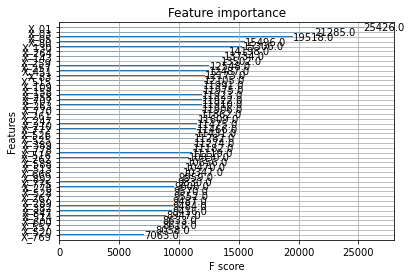

In [103]:
f_score_standard = 1500

import xgboost as xgb
XGB = xgb.XGBRegressor(n_estimators=500, learning_rate=0.01, gamma = 0, subsample=0.75,
 colsample_bytree = 1, max_depth=7,tree_method='gpu_hist', gpu_id=0).fit(train_x, train_y)
valid_preds = XGB.predict(valid_x)
score = lg_nrmse(valid_y.values,valid_preds)
print("파생변수 기본 스코어",score)
from xgboost import plot_importance
plot_importance(XGB.get_booster().get_fscore())


##  기준으로 자르기
a =  XGB.get_booster().get_fscore()
c = {}
new_data = pd.DataFrame()
new_data_vaild = pd.DataFrame()
for i in a:
    if a[i]>f_score_standard:
        new_data[i] = train_x[i]
        new_data_vaild[i] = valid_x[i]
        c[i] = a[i]
print("f_score_standard가",f_score_standard,"일때의 그래프")
from xgboost import plot_importance
plot_importance(c)

import xgboost as xgb
XGB = xgb.XGBRegressor(n_estimators=500, learning_rate=0.01, gamma = 0, subsample=0.75,
 colsample_bytree = 1, max_depth=7,tree_method='gpu_hist', gpu_id=0).fit(new_data, train_y)
valid_preds = XGB.predict(new_data_vaild)
score = lg_nrmse(valid_y.values,valid_preds)
print("f_score_standard로 파생변수 잘랐을때의 점수",score)
print("그때의 그래프")
from xgboost import plot_importance
plot_importance(XGB.get_booster().get_fscore())

[0.2556213912923826, 0.35415162558027197, 0.347083366860999, 0.1882953400649282, 0.07928248555834581, 0.09795879394919009, 0.12866304617167076, 0.025111603847307033]
파생변수 기본 스코어 1.9438402059008113


C:\Users\Public\Documents\ESTsoft\CreatorTemp/ipykernel_25152/922103909.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  new_data[i] = train_x[i]
C:\Users\Public\Documents\ESTsoft\CreatorTemp/ipykernel_25152/922103909.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  new_data_vaild[i] = valid_x[i]


f_score_standard가 500 일때의 그래프
[0.25528678124060855, 0.3540090648411242, 0.3465187536275724, 0.1883021226052745, 0.07929734705246029, 0.09824090774706928, 0.128637119455816, 0.02512549362358537]
f_score_standard로 파생변수 잘랐을때의 점수 1.942988186215489
그때의 그래프


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

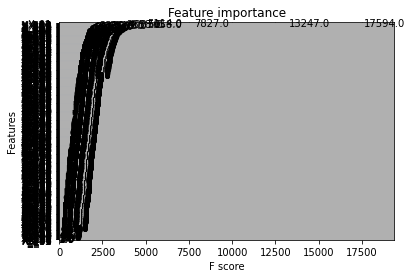

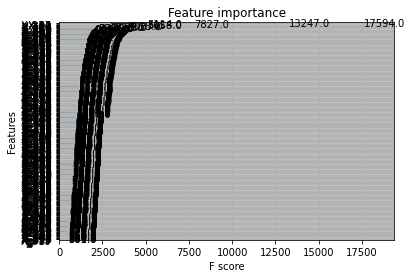

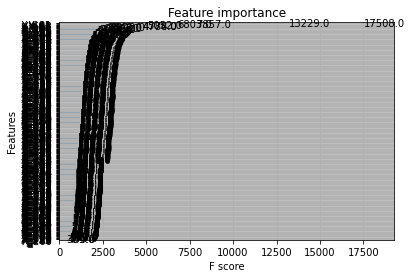

In [104]:
f_score_standard = 500

import xgboost as xgb
XGB = xgb.XGBRegressor(n_estimators=500, learning_rate=0.01, gamma = 0, subsample=0.75,
 colsample_bytree = 1, max_depth=7,tree_method='gpu_hist', gpu_id=0).fit(train_x, train_y)
valid_preds = XGB.predict(valid_x)
score = lg_nrmse(valid_y.values,valid_preds)
print("파생변수 기본 스코어",score)
from xgboost import plot_importance
plot_importance(XGB.get_booster().get_fscore())


##  기준으로 자르기
a =  XGB.get_booster().get_fscore()
c = {}
new_data = pd.DataFrame()
new_data_vaild = pd.DataFrame()
for i in a:
    if a[i]>f_score_standard:
        new_data[i] = train_x[i]
        new_data_vaild[i] = valid_x[i]
        c[i] = a[i]
print("f_score_standard가",f_score_standard,"일때의 그래프")
from xgboost import plot_importance
plot_importance(c)

import xgboost as xgb
XGB = xgb.XGBRegressor(n_estimators=500, learning_rate=0.01, gamma = 0, subsample=0.75,
 colsample_bytree = 1, max_depth=7,tree_method='gpu_hist', gpu_id=0).fit(new_data, train_y)
valid_preds = XGB.predict(new_data_vaild)
score = lg_nrmse(valid_y.values,valid_preds)
print("f_score_standard로 파생변수 잘랐을때의 점수",score)
print("그때의 그래프")
from xgboost import plot_importance
plot_importance(XGB.get_booster().get_fscore())

In [105]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(XGB,new_data,train_y,scoring = 'neg_mean_squared_error',cv=10)

In [106]:
rmse =np.sqrt(-scores)
print(rmse.mean())

1.2058368828317507


In [107]:
scores

array([-1.66854855, -1.5061527 , -1.39376641, -1.38589581, -1.47825027,
       -1.37614504, -1.4213165 , -1.49533914, -1.40602313, -1.42052526])

# 제출

In [111]:
preds = XGB.predict(test_x)
submit = pd.read_csv('./sample_submission.csv')
for idx, col in enumerate(submit.columns):
    if col=='ID':
        continue
    submit[col] = preds[:,idx-1]
print('Done.')
submit.to_csv('./submit_XGBoost_clliping_기본+1.csv', index=False)

ValueError: Feature shape mismatch, expected: 392, got 56

: 